## Crop images
Overlay polygons, create a mask, change pixel dimensions and plot

In [133]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.path import Path

from shapely import wkt
import os
import fnmatch
from rasterio.plot import show
import rasterio as rio
from rasterio.windows import Window
import cv2

import geopandas as gpd

from h3.utils.directories import get_xbd_dir
from h3.utils.directories import get_data_dir

from h3.dataprocessing.extract_metadata import extract_metadata
#from h3.dataprocessing.extract_metadata import extract_damage_allfiles_ensemble
from h3.dataprocessing.extract_metadata import filter_files

Get all necessary paths to files and folders

In [134]:
CLASSES_DICT = {
    "no-damage": 0,
    "minor-damage": 1,
    "major-damage": 2,
    "destroyed": 3,
    "un-classified": 4
}

xbd_dir = get_xbd_dir()
data_dir = get_data_dir()
labels_path = "geotiffs.old/hold/labels/"
filepath = os.path.join(xbd_dir, labels_path, "")
fulldirectory_files = [os.path.join(filepath, file)
                       for file in os.listdir(filepath)]

In [135]:
path_save_pre = os.path.join(data_dir, 
                                  "datasets/processed_data/metadata_pickle",
                                  "pre_polygons_damage_old.pkl")

hallo = pd.read_pickle(path_save_pre)

In [4]:
first_column = hallo.iloc[200]
load_image = first_column["image_name"].replace("png", "tif")

json_path = os.path.join(filepath, load_image)
image_path = json_path.replace("labels", "images")

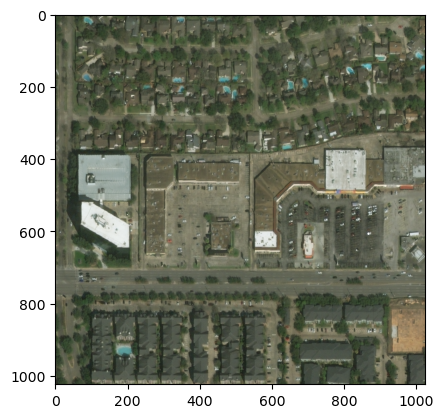

In [137]:
with rio.open(image_path) as img:
    image_array = img.read()
    image_meta = img.profile

    f, ax = plt.subplots()
    ax = rio.plot.show(image_array, ax=ax)  

In [140]:
def polygon_mask(img, polygon, im_size):
    img = img.read()
    image_size = (im_size, im_size)
    
    empty_mask = np.zeros(image_size, np.uint8)
    extract_coords = lambda row: np.array(row).astype(np.int32)
    poly_coords = [extract_coords(polygon.exterior.coords)]
    image_mask = cv2.fillPoly(empty_mask, poly_coords, 1)
    return image_mask

def extract_coords (row):
    return np.array(row).astype(np.int32)


def polygon_mask(img, polygon, im_size):
    img = img.read()
    image_size = (im_size, im_size)

    empty_mask = np.zeros(image_size, np.uint8)
    poly_coords = [extract_coords(polygon.exterior.coords)]
    image_mask = cv2.fillPoly(empty_mask, poly_coords, 1)
    return image_mask

In [141]:
def mask_to_bb(Y):
    nx, ny = np.nonzero(Y)
    # check if polygon is empty
    if len(nx)==0 or len(ny) == 0:  
        return np.zeros(4, dtype=np.float32)
    top_y= np.min(ny)
    bottom_y = np.max(ny)
    left_x = np.min(nx)
    right_x = np.max(nx)
    return np.array([left_x, top_y, right_x, bottom_y], dtype=np.int64)

In [142]:
def crop_images(img, polygon_df, crop_size, im_size):
    polygon_grid = polygon_mask(img, polygon_df, im_size)
    bounding_box = mask_to_bb(polygon_grid)
    x_size, y_size = crop_size, crop_size
    
    # extract bounding box information
    x1 = int(bounding_box[1])
    x2 = int(bounding_box[3]) 
    y1 = int(bounding_box[0])
    y2 = int(bounding_box[2])
    
    x_min = 0
    x_max = img.width - x_size
    y_min = 0
    y_max = img.width - y_size
    
    # find out if house is on the edge and potentially cut off
    # we will not be using incomplete houses
    if x1 == x_min or x2 == x_max or y1 == y_min or y2 == y_max:
        return
    
    if (y2-y1) > y_size or (x2-x1) > x_size:
        # give it an empty array
        print("house is larger than the box!")
        return
    else:
        # find centre point of the bounding box
        x_offset = (x2+x1)//2
        y_offset = (y2+y1)//2
        print(x_offset)
        print(y_offset)
        
    # find out whether the whole environment around house can be imaged
    if (y_offset + y_size/2 > im_size or y_offset - y_size/2 < y_min or 
        x_offset + x_size/2 > im_size or x_offset - x_size/2 < x_min):
        # fill up with Nan
        print("Oh no we have to fill it up")
        print(img)
        return
    else:
        # rasterio Window is a view on a rectangular subset of the raster dataset
        window = Window(x_offset, y_offset, x_size, y_size)
        print(img)
        
        
    # preserve image metadata
    img_bands = img.meta["count"]
    img_crs = img.meta["crs"]
    metadata_profile = img.profile
    metadata_profile.update({
        "height": x_size,
        "width": y_size,
        "count": img_bands,
        "crs": img_crs})
    
    with rio.open("output.tif", "w", **metadata_profile) as src:
        # Read the data from the window and write it to the output raster
        src.write(img.read(window=window))

In [80]:
with rio.open(image_path) as img:
    image_size = 1024
    crop_size = 224
    crop_images(img, first_column["geometry"], crop_size, image_size)   

254
144
<open DatasetReader name='/Users/Lisanne/Documents/AI4ER/hurricane-harm-herald/data/datasets/xBD_data/geotiffs.old/hold/images/hurricane-harvey_00000395_pre_disaster.tif' mode='r'>


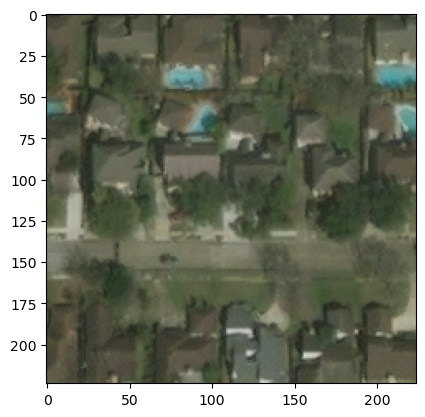

(3, 224, 224)


In [81]:
with rio.open("output.tif") as img2:
    rio.plot.show(img2.read())
    print(img2.read().shape)

- WE NEED CENTERED
- EDGE case: buffer it with NaN
- Split house -> get rid of it

## Implement edge cases

In [40]:
import scipy.ndimage

In [143]:
def crop_images(img, polygon_df, crop_size, pixel_num, im_size):
    polygon_grid = polygon_mask(img, polygon_df, im_size)
    bounding_box = mask_to_bb(polygon_grid)
   # x_size, y_size = crop_size, crop_size
    
    # extract bounding box information
    x1 = int(bounding_box[1])
    x2 = int(bounding_box[3]) 
    y1 = int(bounding_box[0])
    y2 = int(bounding_box[2])
    print("bounding box",bounding_box)
    x_min = 0
    x_max = img.width - crop_size
    y_min = 0
    y_max = img.width - crop_size
    
    # find out if house is on the edge and potentially cut off
    # we will not be using incomplete houses
    if x1 <= x_min or x2 >= img.width or y1 <= y_min or y2 >= img.width:
        print("House is cut off, so will not be included")
        return
    
    if (y2-y1) > crop_size or (x2-x1) > crop_size:
        # give it an empty array
        print("House is larger than the box!")
        return
    else:
        # find centre point of the bounding box
        x_offset = (x2+x1)//2
        y_offset = (y2+y1)//2
    
    # Find out dimensions of image cropping around offset
    size_limit = crop_size//2
    
    # find out whether the whole environment around house can be imaged
    if (y_offset + size_limit > y_max or y_offset - size_limit < y_min or 
        x_offset + size_limit > x_max or x_offset - size_limit < x_min):
        print("Oh no we have to fill it up") 
        image_array = img.read()
        shape = (image_array.shape)
        
        # padding around image, add dimensions around offset to all sides
        pad = ((0, 0), (size_limit, size_limit), (size_limit, size_limit))
        padded = np.pad(image_array, pad_width=pad)
        
        padded_x_offset = x_offset + size_limit
        padded_y_offset = y_offset + size_limit

        rio.plot.show(padded)
        roi = padded[:, (padded_y_offset-size_limit) : (padded_y_offset+size_limit), (padded_x_offset-size_limit):(padded_x_offset+size_limit)]

    else:
        # rasterio Window is a view on a rectangular subset of the raster dataset
        #window = Window(x_offset, y_offset, x_size, y_size)

        image_array = img.read()
        roi = image_array[:, (y_offset-size_limit) : (y_offset+size_limit), (x_offset-size_limit):(x_offset+size_limit)]
    
    
    # We want all images to be a certain pixel size, so we need to downsample/upsample
    # to get zoom levels with same pixel size
    # use rasterio transform
    #resized_img = image_resize(roi, crop_size, pixel_num)
    scaling_factor = pixel_num/crop_size
    print(roi.shape)
    # order 1 = nearest interpolation, order 2= bilinear interpolation, order 3 = cubic
    resized_img = scipy.ndimage.zoom(roi, (1, scaling_factor, scaling_factor), order=1)
    print(resized_img.shape)
        
    # preserve image metadata
    img_bands = img.meta["count"]
    img_crs = img.meta["crs"]
    metadata_profile = img.profile
    metadata_profile.update({
        "height": pixel_num,
        "width": pixel_num,
        "count": img_bands,
        "crs": img_crs})
    
    with rio.open("output.tif", "w", **metadata_profile) as src:
        # Read the data from the window and write it to the output raster
        src.write(resized_img)

bounding box [126 238 163 271]
Oh no we have to fill it up


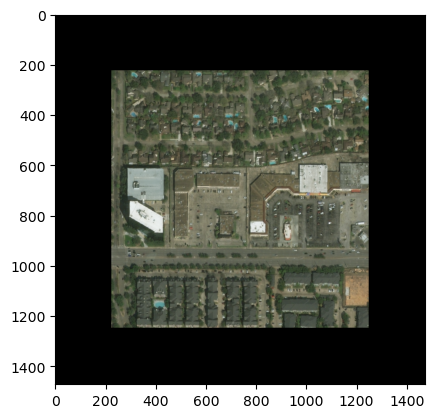

(3, 448, 448)
(3, 224, 224)


In [144]:
with rio.open(image_path) as img:
    image_size = 1024
    crop_size = 448
    pixel_num = 224
    crop_images(img, first_column["geometry"], crop_size, pixel_num, image_size) 

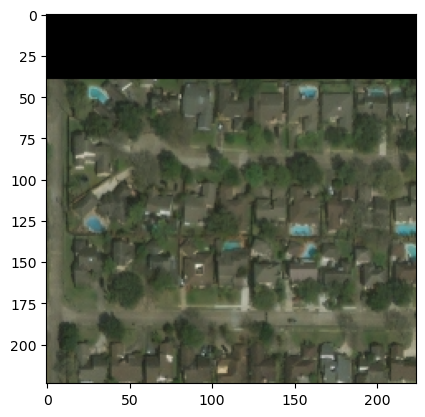

(3, 224, 224)


In [145]:
with rio.open("output.tif") as img2:
   rio.plot.show(img2.read())
   print(img2.read().shape)

## Resize image
Zoom in. Zoom 1x is 224 pixels. Want to maintain pixel size but still want to zoom in 1x or 2x...

# Check crop_images.py

In [ ]:
path = os.path.join(data_dir, "datasets/processed_data/geotiffs_zoom/hold/images/zoom_1", "1.png")
with rio.open(path) as img2:
    rio.plot.show(img2.read())
    print(img2.read().shape)